## USES HAND GESTURE TO PLAY SUBWAY SURFERS

In [1]:
import cv2
import pyautogui
from time import time
from math import hypot
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
from time import sleep


In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

hand_image = mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5, max_num_hands=1)
hand_video = mp_hands.Hands(static_image_mode=False, model_complexity=1, min_detection_confidence=0.7,
                          min_tracking_confidence=0.7, max_num_hands=1)

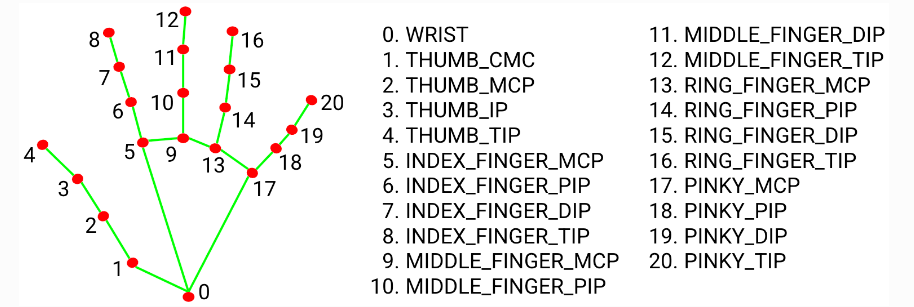
hand landmark pts

In [3]:
def detectHands(image, hand_fn, draw=False, display=False):
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = hand_fn.process(imageRGB)
    
    if results.multi_hand_landmarks and draw:
            for num, hand in enumerate(results.multi_hand_landmarks):
                mp_drawing.draw_landmarks(output_image, hand, mp_hands.HAND_CONNECTIONS, 
                                        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                         )
    
    if display:
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off')
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off')
    else:
        return output_image, results
    

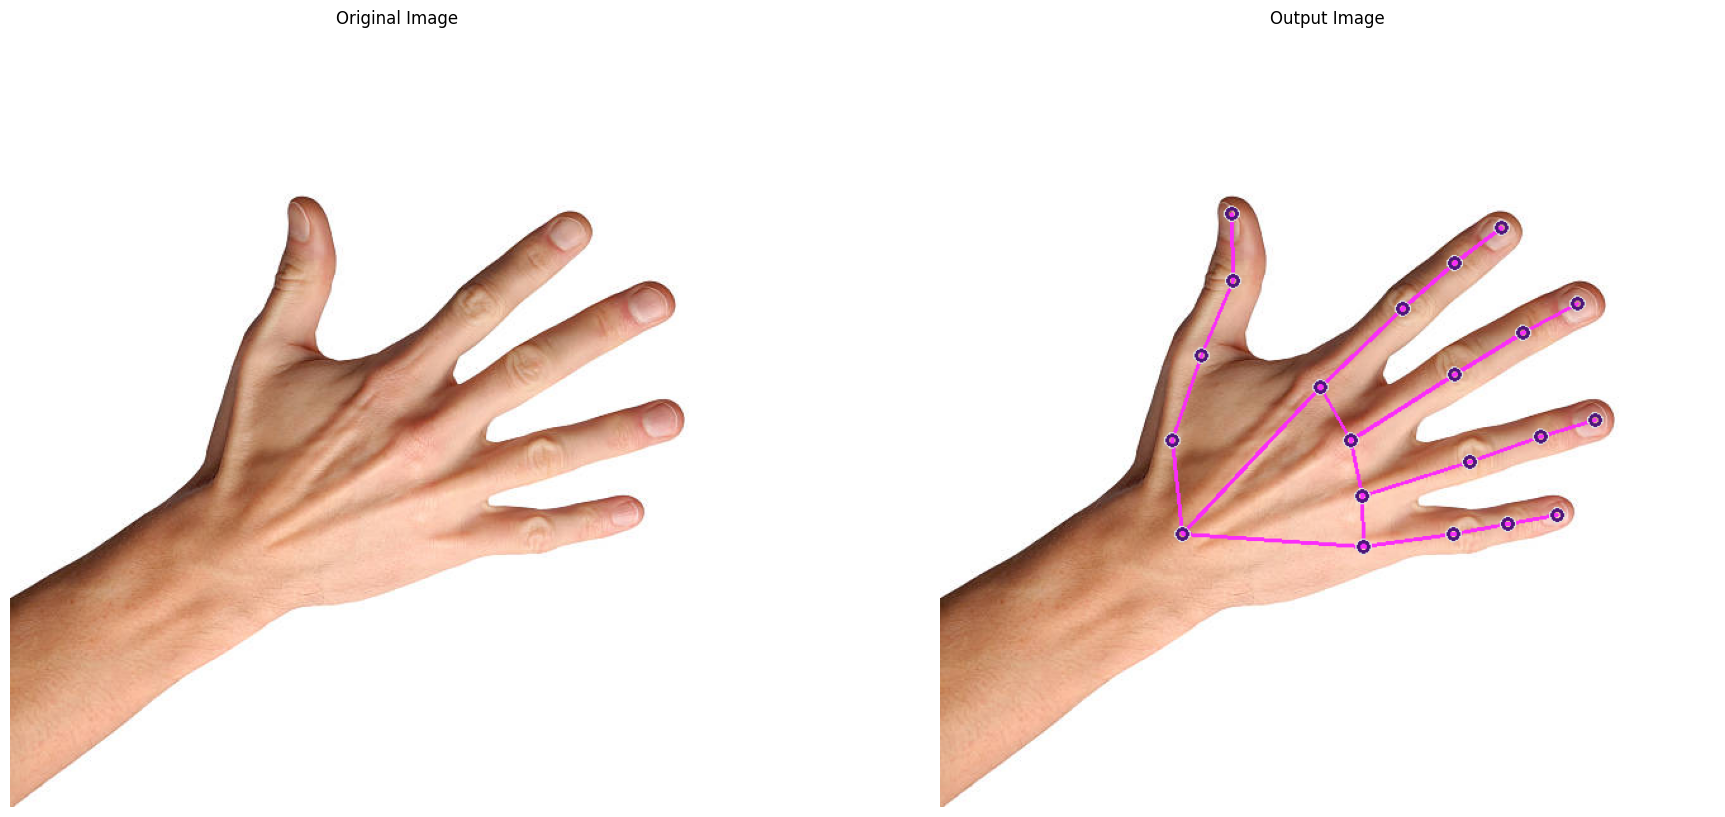

In [4]:
IMG_PATH = 'images/smaple2.jpg'
image = cv2.imread(IMG_PATH)
detectHands(image, hand_image, draw=True, display=True)

In [5]:
def checkPinch(image, results, draw=False, display=False):
    '''
        checks if the first finger and thumb are pinching....for starting the game
    '''
    height, width, _ = image.shape
    output_image = image.copy()
    
    one_hand = results.multi_hand_landmarks[0].landmark
    
    # print(one_hand.landmark[4])
    # return 
    
    thumbtip_landmark = (one_hand[4].x*width,
                      one_hand[4].y*height)
    
    indextip_landmark = (one_hand[8].x*width,
                      one_hand[8].y*height)
    
    x1, y1 = int(indextip_landmark[0]), int(indextip_landmark[1])
    x2, y2 = int(thumbtip_landmark[0]), int(thumbtip_landmark[1])
    
    dist = int(hypot(thumbtip_landmark[0]-indextip_landmark[0],
                      thumbtip_landmark[1]-indextip_landmark[1]))
    
    if dist < 20:
        pinch_status = 'Pinched'
        color = (0, 255, 0)
    else:
        pinch_status = 'Not Pinched'
        color = (255, 0, 0)
        
        
    if draw:
        cv2.putText(output_image, pinch_status, (10,30), cv2.FONT_HERSHEY_PLAIN, 2, color, 3)
        cv2.putText(output_image, f'Distance: {dist}', (10, 70), cv2.FONT_HERSHEY_PLAIN, 2, color, 3) 
        cv2.circle(output_image, (x1, y1), 10, (255, 0, 128), cv2.FILLED)
        cv2.circle(output_image, (x2, y2), 10, (255, 0, 128), cv2.FILLED)
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 128), 3)
        
        
    if display:
        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    # Otherwise
    else:
        # Return the output image and the classified hands status indicating whether the hands are joined or not.
        return output_image, pinch_status  

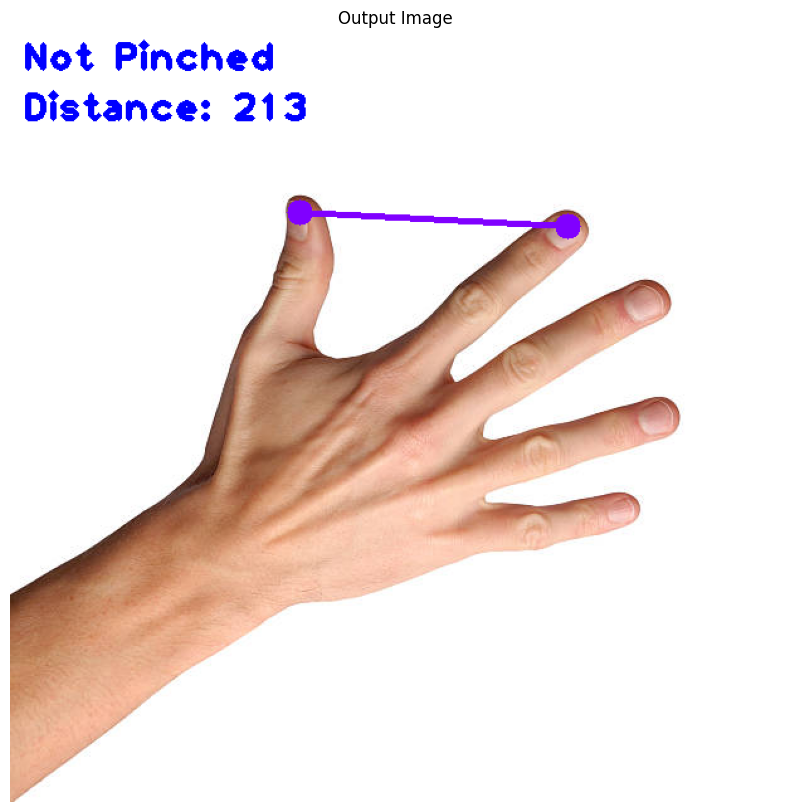

In [6]:
IMG_PATH = 'images/smaple2.jpg'
image = cv2.imread(IMG_PATH)
frame, results = detectHands(image, hand_video, draw=True)
checkPinch(image, results, draw=True, display=True)

In [7]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 960)

cv2.namedWindow('Pinches?' , cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    ok, frame = camera_video.read()
    
    if not ok:
        continue
    
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    
    frame, results = detectHands(frame, hand_video, draw=True)
    
    if results.multi_hand_landmarks:
        frame, _ = checkPinch(frame, results, draw=True)
    
    cv2.imshow('Pinches?', frame)
    
    k = cv2.waitKey(1) & 0xFF 
    if k == 27:
        break

camera_video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [8]:
# HORIZONTAL CONTROL
def checkLeftRight(image, results, draw=False, display=False):
    horizonatal_positon = None
    height, width, _ = image.shape
    
    output_image = image.copy()
    one_hand = results.multi_hand_landmarks[0].landmark
    
    left_x = int(one_hand[4].x * width) # thumb tip
    right_x = int(one_hand[20].x * width) # pinkie tip
    
    # obvious shit
    if (right_x <= width//2 and left_x <= width//2):
        horizontal_position = 'Left'
    elif (right_x >= width//2 and left_x >= width//2):
        horizontal_position = 'Right'
    elif (right_x >= width//2 and left_x <= width//2):
        horizontal_position = 'Center'
    else:
        horizontal_position = 'None'
    
    if draw and horizonatal_positon != 'None':
        cv2.putText(output_image, horizontal_position, (5, height - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
        cv2.line(output_image, (width//2, 0), (width//2, height), (255, 255, 255), 2)
        
    
    # Check if the output image is specified to be displayed.
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    else:
        return output_image, horizontal_position

In [89]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 960)

cv2.namedWindow('Horizontal Psoiton?' , cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    ok, frame = camera_video.read()
    
    if not ok:
        continue
    
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    
    frame, results = detectHands(frame, hand_video, draw=True)
    
    if results.multi_hand_landmarks:
        frame, _ = checkLeftRight(frame, results, draw=True)
    
    cv2.imshow('Horizontal moves?', frame)
    
    k = cv2.waitKey(1) & 0xFF 
    if k == 27:
        break

camera_video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [9]:
# VERTICAL CONTROL
def checkTopBottom(image, results,MID_Y=250, draw=False, display=False):
    height, width, _ = image.shape
    
    output_image = image.copy()
    one_hand = results.multi_hand_landmarks[0].landmark
    
    left_y = int(one_hand[4].y * height) # thumb tip
    right_y = int(one_hand[20].y * height) # pinkie tip
    
    actual_mid_y = abs((left_y + right_y) // 2)
    
    lower_y = MID_Y - 50
    upper_y = MID_Y + 50
    
    if (actual_mid_y < lower_y):
        posture = 'Jumping'
    elif (actual_mid_y > upper_y):
        posture = 'Crouching'  
    else:
        posture = 'Standing'
       
       
    if draw:
        cv2.putText(output_image, posture, (5, height - 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
        cv2.line(output_image, (0, MID_Y),(width, MID_Y),(255, 255, 255), 2)
        cv2.line(output_image, (0, lower_y),(width, lower_y),(255, 0, 255), 2)
        cv2.line(output_image, (0, upper_y),(width, upper_y),(255, 255, 0), 2)
        
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    else:
        return output_image, posture

In [85]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 960)

cv2.namedWindow('Vertical Position?' , cv2.WINDOW_FREERATIO)

while camera_video.isOpened():
    ok, frame = camera_video.read()
    
    if not ok:
        continue
    
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    
    frame, results = detectHands(frame, hand_video, draw=True)
    
    if results.multi_hand_landmarks:
        frame, _ = checkTopBottom(frame, results, draw=True)
    
    cv2.imshow('Vertical moves?', frame)
    
    k = cv2.waitKey(1) & 0xFF 
    if k == 27:
        break

camera_video.release()
cv2.destroyAllWindows()

In [9]:
# ALL 2 CONTROLS TOGETHER

camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 960)

cv2.namedWindow('Both Control' , cv2.WINDOW_FREERATIO)

while camera_video.isOpened():
    ok, frame = camera_video.read()
    
    if not ok:
        continue
    
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    
    frame, results = detectHands(frame, hand_video, draw=True)
    
    if results.multi_hand_landmarks:
        frame, _ = checkTopBottom(frame, results, draw=True)
        frame, _ = checkLeftRight(frame, results, draw=True)
    
    cv2.imshow('Both moves?', frame)
    
    k = cv2.waitKey(1) & 0xFF 
    if k == 27:
        break

camera_video.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

### finally integrating it with pyautogui`

In [10]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 960)

cv2.namedWindow('Subway Surfers with Pose Detection', cv2.WINDOW_NORMAL)

time1 = 0
game_started = False

x_pos_index = 1 # left-0 , center-1, right-2
y_pos_index = 1 # crouch-0, center-1, jump-2

counter = 0 # for the number of frames we ahve to pinch to start the game
num_of_frames = 10

MID_Y = None

while camera_video.isOpened():
    ok, frame = camera_video.read()
    
    if not ok: 
        continue
    
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    
    frame, results = detectHands(frame, hand_video, draw=True)
    
    if results.multi_hand_landmarks:
        
        if game_started:
            frame, horizontal_position = checkLeftRight(frame, results, draw=True)
            
            if (horizontal_position == 'Left' and x_pos_index != 0) or (horizontal_position=='Center' and x_pos_index==2):
                pyautogui.press('left')
                x_pos_index -= 1
                
            elif (horizontal_position=='Right' and x_pos_index!=2) or (horizontal_position=='Center' and x_pos_index==0):
                pyautogui.press('right')
                x_pos_index += 1
                
            if MID_Y:
                frame, posture = checkTopBottom(frame, results, MID_Y, draw=True)
                if posture == 'Jumping' and y_pos_index == 1:
                    pyautogui.press('up')
                    y_pos_index += 1 
                elif posture == 'Crouching' and y_pos_index == 1:
                    pyautogui.press('down')
                    y_pos_index -= 1 
                elif posture == 'Standing' and y_pos_index   != 1:
                    y_pos_index = 1
        
        else:
            cv2.putText(frame, 'Pinch your index and thumb together to START.', (5, frame_height - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
            
        ##--------------------------------------------------------------------------------------------------------
        
        if checkPinch(frame, results)[1] == 'Pinched':
            counter+=1
            
            if counter == num_of_frames:
                if not(game_started): #if game not started then start it
                    game_started = True
                    
                    one_hand = results.multi_hand_landmarks[0].landmark
                    
                    left_y = int(one_hand[4].y * frame_height) # thumb tip
                    right_y = int(one_hand[20].y * frame_height) # pinkie tip
                    
                    MID_Y = abs(left_y + right_y) // 2
                    
                    pyautogui.press('space') #press space to start the game
                    
                else: #if gam is started and still pincehd.....then press space again to pause the game
                    pyautogui.press('space')
                    
                counter = 0 #reset the counter
                
        else:
            counter = 0 #reset counter

        
        
    else:
        counter = 0
            
    time2 = time()
    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {:.1f}'.format(frames_per_second), (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    time1 = time2
    
    # Display the frame.            
    cv2.imshow('Subway Surfers with Pose Detection', frame)
    k = cv2.waitKey(1) & 0xFF     
    if(k == 27):
        break
 
# Release the VideoCapture Object and close the windows.                  
camera_video.release()
cv2.destroyAllWindows()
                        